In [1]:
import os, sys
sys.path.insert(1, '../')

from importlib import reload
from tqdm import tqdm
from time import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import QuantileRegressor

import utils

import matplotlib
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns

## Load predictions and labels

This file is from https://github.com/1edv/evolution/blob/0381cd057b2ac0c7e5bfbcf603d42c785034b91e/manuscript_code/model/results_summary/Native_allchunks_test_tpu_model.csv, which are the predictions and labels plotted in [Extended Data Fig. 3e](https://www-nature-com.libproxy.berkeley.edu/articles/s41586-022-04506-6/figures/7) of [Vaishnav et al. (2022), _Nature_](https://www-nature-com.libproxy.berkeley.edu/articles/s41586-022-04506-6).

In [2]:
data_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
data_df

,sequence,measured,predicted
index,,,
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.825806,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAATTTAAAGAATTTC...,11.412778,9.643128
2,TGCATTTTTTTCACATCAAAAAAAAGGACGTTCCACACTTGGCTGC...,10.623805,11.864820
3,TGCATTTTTTTCACATCAAAATCCGTGTAATACCAAGTCATCCTCA...,7.703389,8.650239
4,TGCATTTTTTTCACATCAGAAAAAAAGTATAATGTCAGATTTTTGT...,11.397473,13.881278
...,...,...,...
61145,TGCATTTTTTTCACATCAGAAAAAAAAAAAAAAAAAAAAAAAGAAA...,14.220082,12.520042
61146,TGCATTTTTTTCACATCAGAAAAAAAAAAAAGAGGAGACTTGAAGA...,6.978840,7.298204
61147,TGCATTTTTTTCACATCAGAAAAAAAAAAGGGATTGGGCGGTAATG...,3.917299,8.096985


This is the experiment whose results are plotted in Figure 11.

In [ ]:
reload(utils)
n_trial = 1000
qs = [0.25, 0.5, 0.75]
ns = np.logspace(np.log10(50), np.log10(2000), num=10, base=10).astype(int)[::-1]
alpha = 0.1
save = True
save_fname = 'iid-clt-results-011722.csv'

y_all = data_df.measured.to_numpy()
f_all = data_df.predicted.to_numpy()

columns = ['q', 'n', 'width', 'covered', 'estimator', 'lower', 'upper']
results = []
for q_idx, q in enumerate(qs):
    for n_idx, n in enumerate(ns):
        for _ in tqdm(range(n_trial)):
            
            q_true, ci_pp, ci_cl  = utils.get_quantile_intervals(y_all, f_all, q, n, alpha)
            
            # check empirical coverage
            cov_cl = (ci_cl[0] <= q_true) & (ci_cl[1] >= q_true)
            cov_pp = (ci_pp[0] <= q_true) & (ci_pp[1] >= q_true)
            
            # record results
            results.append([q, n, ci_pp[1] - ci_pp[0], int(cov_pp), 'prediction-powered', ci_pp[0], ci_pp[1]])
            results.append([q, n, ci_cl[1] - ci_cl[0], int(cov_cl), 'classical', ci_cl[0], ci_cl[1]])
            
        # save results
        df = pd.DataFrame(results, columns=columns)
        if save:
            df.to_csv(save_fname)
        
        # print results
        print('n = {}, q = {}'.format(n, q))
        print('  avg. classical width: {:.2f}, avg. PP width: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].width.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].width.mean()
        ))
        print('  avg. classical cov: {:.2f}, avg. PP cov: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].covered.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].covered.mean()
        ))

## Plot comparison of interval widths

In [40]:
# load results from previous cell
df = pd.read_csv('iid-clt-results-011722.csv', index_col=0)
df

,q,n,width,covered,estimator,lower,upper
0,0.25,2000,0.210000,1,prediction-powered,2.864698,3.074698
1,0.25,2000,0.211692,1,classical,2.772702,2.984394
2,0.25,2000,0.200000,1,prediction-powered,2.821820,3.021820
3,0.25,2000,0.208788,1,classical,2.819099,3.027887
4,0.25,2000,0.200000,1,prediction-powered,2.886392,3.086392
...,...,...,...,...,...,...,...
59995,0.75,49,5.476777,1,classical,6.037432,11.514209
59996,0.75,49,3.530000,1,prediction-powered,7.139431,10.669431
59997,0.75,49,4.606437,1,classical,6.740266,11.346702
59998,0.75,49,3.580000,1,prediction-powered,9.124217,12.704217


Figure 11.

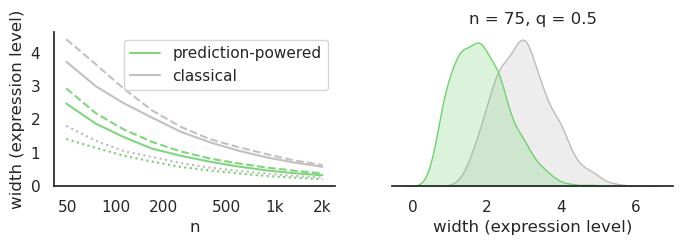

In [42]:
save = True
n_to_plot = 75
plot_df = df.loc[(df.q == 0.5) & (df.n == n_to_plot)]
c_cl, c_pp = "#BFB9B9", "#71D26F"
ns = np.logspace(np.log10(50), np.log10(2000), num=10, base=10).astype(int)
ns_xticks = [50, 100, 200, 500, 1000, 2000]
ns_xticklabels = [50, 100, 200, 500, '1k', '2k']

fig, axs = plt.subplots(1, 2, figsize=(8, 2))
for q, ls in zip([0.25, 0.5, 0.75], [':', '-', '--']):
    dfqn = df.loc[df.q == q]
    wcl_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'classical')].width.mean()for n in ns])
    wpp_n = np.array(
        [dfqn.loc[(dfqn.n == n) & (dfqn.estimator == 'prediction-powered')].width.mean()for n in ns])
    axs[0].plot(
        ns, wpp_n,
        label='prediction-powered' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_pp)
    axs[0].plot(
        ns, wcl_n,
        label='classical' if q == 0.5 else None,
        alpha=0.9 if q > 0.25 else 1, linestyle=ls, c=c_cl)
    
axs[0].set_xscale('log')
axs[0].set_xticks(ns_xticks)
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xticklabels(ns_xticklabels)
axs[0].set_xlabel('n');
axs[0].set_ylabel('width (expression level)')
axs[0].legend();
sns.despine(ax=axs[0],top=True,right=True)

my_palette = sns.color_palette([c_pp, c_cl], 2)
sns.set_theme(style="white", palette=my_palette)
kde = sns.kdeplot(
    plot_df, x="width", hue="estimator", hue_order=["prediction-powered", "classical"],
    fill=True, ax=axs[1])
kde.get_legend().remove()
sns.despine(ax=axs[1],top=True,right=True,left=True)
axs[1].set_xlabel("width (expression level)")
axs[1].set_ylabel('')
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_title('n = {}, q = 0.5'.format(n_to_plot));
if save:
    plt.savefig('figures/widths.png', dpi=300, bbox_inches='tight')
plt.show()

## Plot example set of intervals

Right subplot of Figure 10.

/home/clarafy/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error in 3.6


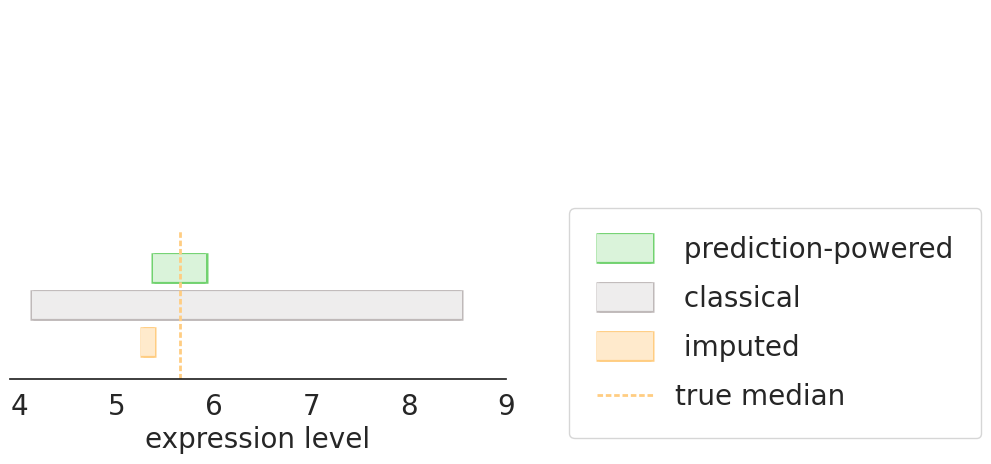

In [46]:
q = 0.5
n = 75
tmp = df.loc[(df.q == q) & (df.n == n)]
cl_df = tmp[1::2]
pp_df = tmp[0::2]
trial = 222
save = True

# true median gene expression
data_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
theta_star = np.quantile(data_df.measured, 0.5)

# construct naive confidence interval
f_all = data_df.predicted.to_numpy()
f_all = 20 * (f_all - np.min(f_all)) / (np.max(f_all) - np.min(f_all))
ci_naive = utils.get_classical_ci(f_all, 0.5, 0.1)

ci_pp = [pp_df.iloc[trial].lower, pp_df.iloc[trial].upper]
ci_cl = [cl_df.iloc[trial].lower, cl_df.iloc[trial].upper]

plt.figure(figsize=(6.4,4.8))
plt.plot(
    ci_pp,[0.3, 0.3],
    linewidth=20, color="#DAF3DA", solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#71D26F"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#71D26F"),
        pe.Normal()
    ],
    label=' prediction-powered'
)
plt.plot(
    ci_cl, [0.2, 0.2],
    linewidth=20, color="#EEEDED",
    solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#BFB9B9"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#BFB9B9"),
        pe.Normal()
    ],
    label=' classical'
)
plt.plot(
    ci_naive, [0.1, 0.1],
    linewidth=20, color="#FFEACC", 
    solid_capstyle='butt',
    path_effects=[
        pe.Stroke(linewidth=22, offset=(-1, 0), foreground="#FFCD82"),
        pe.Stroke(linewidth=22, offset=(1, 0), foreground="#FFCD82"),
        pe.Normal()
    ],
    label=' imputed'
)
plt.plot(
    [theta_star, theta_star], [0, 0.4], linestyle='--', dashes=(2, 1), linewidth=2,
    label="true median", color="#FFCD82"
)
plt.xlabel("expression level", fontsize=20)
plt.yticks([], labels=[])
plt.xticks(range(4, 10), fontsize=20)
plt.ylim([0,1])
leg = plt.legend(fontsize=20, borderpad=1, labelspacing = 0.75, bbox_to_anchor=[1.1,0.5])
sns.despine(ax=plt.gca(),top=True,right=True,left=True)

if save:
    plt.savefig('./figures/intervals.pdf', ppi=300, bbox_inches='tight')
plt.show()

## Plot predictions vs. gold-standard labels to illustrate predictive performance

Middle subplot of Figure 10.

In [3]:
data_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
data_df

,sequence,measured,predicted
index,,,
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.825806,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAATTTAAAGAATTTC...,11.412778,9.643128
2,TGCATTTTTTTCACATCAAAAAAAAGGACGTTCCACACTTGGCTGC...,10.623805,11.864820
3,TGCATTTTTTTCACATCAAAATCCGTGTAATACCAAGTCATCCTCA...,7.703389,8.650239
4,TGCATTTTTTTCACATCAGAAAAAAAGTATAATGTCAGATTTTTGT...,11.397473,13.881278
...,...,...,...
61145,TGCATTTTTTTCACATCAGAAAAAAAAAAAAAAAAAAAAAAAGAAA...,14.220082,12.520042
61146,TGCATTTTTTTCACATCAGAAAAAAAAAAAAGAGGAGACTTGAAGA...,6.978840,7.298204
61147,TGCATTTTTTTCACATCAGAAAAAAAAAAGGGATTGGGCGGTAATG...,3.917299,8.096985


In [12]:
# fit median regressor with handful of data points
# (this is also done in utils.get_quantile_intervals())
y_all = data_df.measured.to_numpy()
f_all = data_df.predicted.to_numpy()
y_train, y_N, f_train, f_N = train_test_split(y_all, f_all, train_size=10)
predictor = QuantileRegressor(quantile=0.5, alpha=1e-6)
predictor.fit(f_train[:, None], y_train)
f_N = predictor.predict(f_N[:, None])

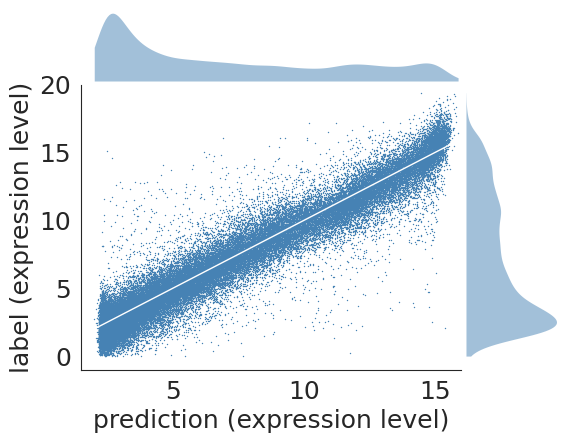

In [13]:
save = True
sns.set_style('white')
fig = plt.figure(figsize=(6, 4.5))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.02, hspace=0.02)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])

ax.scatter(f_N, y_N, s=1, linewidth=0, alpha=1, c='steelblue')
ax.plot([0, 20], [0, 20], c='w', linewidth=1)
ax.set_xlim([1.5, 16])
ax.set_ylim([-1, 20])
ax.set_xticks(range(5, 19, 5))
ax.set_yticks(range(0, 21, 5))
ax.set_xticklabels(range(5, 19, 5), fontsize=18)
ax.set_yticklabels(range(0, 21, 5), fontsize=18)
ax.set_xlabel('prediction (expression level)', fontsize=18)
ax.set_ylabel('label (expression level)', fontsize=18)


sns.kdeplot(ax=ax_histx, data=f_N, fill=True, alpha=0.5, cut=0, linewidth=0, color='steelblue')
sns.kdeplot(ax=ax_histy, y=y_N, fill=True, alpha=0.5, cut=0, linewidth=0, color='steelblue')
ax_histx.set_xlim([1.5, 16])
ax_histx.set_xticks([])
ax_histx.set_yticks([])
ax_histx.set_ylabel('')
ax_histy.set_ylim([-1, 20])
ax_histy.set_xticks([])
ax_histy.set_yticks([])
ax_histy.set_xlabel('')

sns.despine(ax=ax, top=True, right=True)
sns.despine(ax=ax_histx, top=True, right=True, bottom=True, left=True)
sns.despine(ax=ax_histy, top=True, right=True, bottom=True, left=True)

plt.show()
if save:
    fig.savefig('figures/model.png', dpi=300, bbox_inches='tight');